### Download ESA SIC data from CEDA & store in zarr.

In [1]:
import os
import sys
import datetime
import calendar
import requests
from cryptography import x509
from cryptography.hazmat.backends import default_backend
from contrail.security.onlineca.client import OnlineCaClient
import xarray as xr
import warnings
import rioxarray
import geopandas as gpd
import logging
import matplotlib.pyplot as plt
import pandas as pd
import zarr

/Users/Zach/miniforge3/lib/python3.9/site-packages/xarray/backends/cfgrib_.py:27: UserWarning: Failed to load cfgrib - most likely there is a problem accessing the ecCodes library. Try `import cfgrib` to get the full error message
  warnings.warn(


In [2]:
# Get CEDA username and password from environment variables
username = os.environ['CEDA_USERNAME']
password = os.environ['CEDA_PASSWORD']

# Credentials defaults
DODS_FILE_CONTENTS = """HTTP.COOKIEJAR=./dods_cookies
HTTP.SSL.CERTIFICATE=./credentials.pem
HTTP.SSL.KEY=./credentials.pem
HTTP.SSL.CAPATH=./ca-trustroots
"""

DODS_FILE_PATH = os.path.expanduser('~/.dodsrc')
CERTS_DIR = os.path.expanduser('~/.certs')

if not os.path.isdir(CERTS_DIR):
    os.makedirs(CERTS_DIR)

TRUSTROOTS_DIR = os.path.join(CERTS_DIR, 'ca-trustroots')
CREDENTIALS_FILE_PATH = os.path.join(CERTS_DIR, 'credentials.pem')

TRUSTROOTS_SERVICE = 'https://slcs.ceda.ac.uk/onlineca/trustroots/'
CERT_SERVICE = 'https://slcs.ceda.ac.uk/onlineca/certificate/'


def write_dods_file_contents():

    DODS_FILE_CONTENTS = """
    HTTP.COOKIEJAR=./dods_cookies
    HTTP.SSL.CERTIFICATE={credentials_file_path}
    HTTP.SSL.KEY={credentials_file_path}
    HTTP.SSL.CAPATH={trustroots_dir}
    """.format(credentials_file_path=CREDENTIALS_FILE_PATH, trustroots_dir=TRUSTROOTS_DIR)

    with open(DODS_FILE_PATH, 'w') as dods_file:
        dods_file.write(DODS_FILE_CONTENTS)


def cert_is_valid(cert_file, min_lifetime=0):
    """
    Returns boolean - True if the certificate is in date.
    Optional argument min_lifetime is the number of seconds
    which must remain.
    :param cert_file: certificate file path.
    :param min_lifetime: minimum lifetime (seconds)
    :return: boolean
    """
    try:
        with open(cert_file, 'rb') as f:
            crt_data = f.read()
    except IOError:
        return False

    try:
        cert = x509.load_pem_x509_certificate(crt_data, default_backend())
    except ValueError:
        return False

    now = datetime.datetime.now()

    return (cert.not_valid_before <= now
            and cert.not_valid_after > now + datetime.timedelta(0, min_lifetime))


def setup_credentials(force=False):
    """
    Download and create required credentials files.
    Return True if credentials were set up.
    Return False is credentials were already set up.
    :param force: boolean
    :return: boolean
    """
    # Test for DODS_FILE and only re-get credentials if it doesn't
    # exist AND `force` is True AND certificate is in-date.
    if os.path.isfile(DODS_FILE_PATH) and not force and cert_is_valid(CREDENTIALS_FILE_PATH):
        print('[INFO] Security credentials already set up.')
        return False

    onlineca_client = OnlineCaClient()
    onlineca_client.ca_cert_dir = TRUSTROOTS_DIR

    # Set up trust roots
    trustroots = onlineca_client.get_trustroots(
        TRUSTROOTS_SERVICE,
        bootstrap=True,
        write_to_ca_cert_dir=True)

    # Write certificate credentials file
    key_pair, certs = onlineca_client.get_certificate(
        username,
        password,
        CERT_SERVICE,
        pem_out_filepath=CREDENTIALS_FILE_PATH)

    # Write the dodsrc credentials file
    write_dods_file_contents()

    print('[INFO] Security credentials set up.')
    return True

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    setup_credentials(force=False)

[INFO] Security credentials set up.


In [4]:
log_filename = 'history.log'
logging.basicConfig(filename=log_filename,
                            filemode='a',
                            format='%(asctime)s,%(msecs)d %(name)s %(levelname)s %(message)s',
                            datefmt='%H:%M:%S',
                            level=logging.INFO
                   )

if not os.path.exists(log_filename):
    with open(log_filename, 'w') as fp:
        pass

exclude_vars = [
    'time_bnds',
    'raw_ice_conc_values',
    'smearing_standard_error',
    'algorithm_standard_error',
]

aoi = gpd.read_file('aoi')  # This is our area of interest.

def get_all_files_by_month(start_date=datetime.datetime(2015, 1, 1), end_date=datetime.datetime(2015, 6, 1)):
    """Generate list of CEDA OpenDAP SIC files split by month"""
    
    # Define URL path and pattern
    base_url = "http://dap.ceda.ac.uk/thredds/dodsC/neodc/esacci/sea_ice/data/sea_ice_concentration/L4/amsr/25km/v2.1/NH"
    filename_pattern = 'ESACCI-SEAICE-L4-SICONC-AMSR_25.0kmEASE2-NH-{year}{month:02}{day:02}-fv2.0.nc'
    
    # Loop over each year and month
    for dt in pd.date_range(start_date, end_date, freq='MS'):
        year, month = dt.year, dt.month
        dir_url = os.path.join(base_url, str(year), str(month).zfill(2))
        
        # Loop over every day of the month and build list of urls
        month_urls = []
        for day in range(1, calendar.monthrange(year, month)[1] + 1):
            url = os.path.join(dir_url, filename_pattern.format(year=year, month=month, day=day))
            month_urls.append(url)
            
        yield month_urls
        
class NoDataException(Exception):
    pass

def open_mfdataset_with_ignore(paths, concat=True, **kwargs):
    """Call xr.open_mfdataset and ignore paths which raise an OSError"""
    ds_list = []
    for path in paths:
        try:
            ds_list.append(xr.open_dataset(path, **kwargs))
        except OSError:
            logging.info(f'No data found for: {path}')
    
    if len(ds_list) == 0:
        raise NoDataException('All supplied paths raised OSError!')
    
    logging.info(f'Read data for {len(ds_list)}/{len(paths)} paths')
    if concat:
        return xr.concat(ds_list, dim='time')
    else:
        return ds_list

In [4]:
out_filepath = 'CEDA_SIC.zarr'

logging.info(f'Beginning process...')

i = 0
for urls in get_all_files_by_month(start_date=datetime.datetime(2015, 4, 1)):
    
    # Open datasets
    logging.info(f'Reading {len(urls)} files...')
    
    try:
        ds_list = open_mfdataset_with_ignore(urls, concat=False, engine='netcdf4', drop_variables=exclude_vars)
    except NoDataException:
        logging.info('No data for this batch!')
        continue
        
    logging.info('Finished.')
    
    for idx, ds in enumerate(ds_list):
        # Set CRS and reproject AOI
        crs = '+proj=laea +lat_0=90 +lon_0=0 +x_0=0 +y_0=0 +ellps=WGS84 +units=km +no_defs +type=crs'
        ds = ds.rename({'xc':'x', 'yc':'y'})
        ds = ds.rio.write_crs(crs)
        aoi = aoi.to_crs(crs)

        # Remove grid_mapping since it causes an overwrite error(?)
        for data_var in ds.data_vars:
            del ds[data_var].attrs['grid_mapping']

        # Clip to AOI
        ds_list[idx] = ds.rio.clip(aoi.geometry)
        
    ds = xr.concat(ds_list, dim='time')
    
    # Save to Zarr
    s_date, e_date = str(ds.time.values[0])[:10], str(ds.time.values[-1])[:10]
    
    if os.path.exists(out_filepath):
        logging.info(f'Appending to {out_filepath} with data from {s_date} to {e_date}...')
        ds.to_zarr(out_filepath, mode='a', append_dim='time')
    else:
        logging.info(f'Creating {out_filepath} with data from {s_date} to {e_date}...')
        ds.to_zarr(out_filepath, mode='w')
        
    logging.info('Done.')
    
    i += 1
        
logging.info(f'...finished process.')

syntax error, unexpected WORD_WORD, expecting SCAN_ATTR or SCAN_DATASET or SCAN_ERROR
context: <html^><head><title>500 Internal Server Error</title></head><body><center><h1>500 Internal Server Error</h1></center><hr><center>nginx</center></body></html>
syntax error, unexpected WORD_WORD, expecting SCAN_ATTR or SCAN_DATASET or SCAN_ERROR
context: <html^><head><title>500 Internal Server Error</title></head><body><center><h1>500 Internal Server Error</h1></center><hr><center>nginx</center></body></html>


### Testing

In [77]:
urls = ["http://dap.ceda.ac.uk/thredds/dodsC/neodc/esacci/sea_ice/data/sea_ice_concentration/L4/amsr/25km/v2.0/NH/2014/01/ESACCI-SEAICE-L4-SICONC-AMSR_25.0kmEASE2-NH-20140101-fv2.0.nc"]
ds = dataset = xr.open_mfdataset(urls, engine="netcdf4")
ds = ds[vars_of_interest].rename({'xc':'x', 'yc':'y'})

In [78]:
# Set CRS and reproject AOI
crs = '+proj=laea +lat_0=90 +lon_0=0 +x_0=0 +y_0=0 +ellps=WGS84 +units=km +no_defs +type=crs'
ds = ds.rio.write_crs(crs)
aoi = aoi.to_crs(crs)

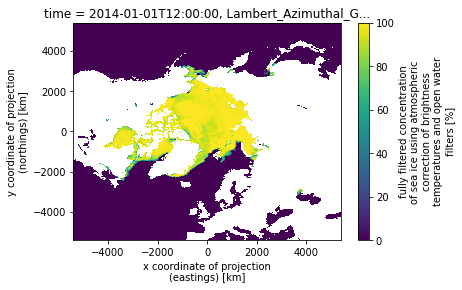

In [79]:
ds.ice_conc.isel(time=-1).plot()

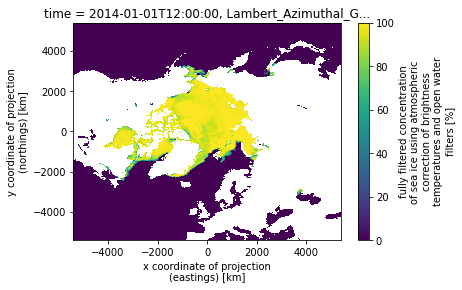

In [35]:
ds.ice_conc.isel(time=0).plot()

In [28]:
ds.rio.clip(aoi.geometry)

<xarray.Dataset>
Dimensions:                   (y: 51, x: 63, time: 1)
Coordinates:
  * y                         (y) float64 312.5 287.5 262.5 ... -912.5 -937.5
  * x                         (x) float64 -4.212e+03 -4.188e+03 ... -2.662e+03
  * time                      (time) datetime64[ns] 2014-01-01T12:00:00
    lat                       (y, x) float32 ...
    lon                       (y, x) float32 ...
    Lambert_Azimuthal_Grid    int64 0
Data variables:
    ice_conc                  (time, y, x) float64 nan nan nan ... nan nan nan
    raw_ice_conc_values       (time, y, x) float64 nan nan nan ... nan nan nan
    total_standard_error      (time, y, x) float64 nan nan nan ... nan nan nan
    smearing_standard_error   (time, y, x) float64 nan nan nan ... nan nan nan
    algorithm_standard_error  (time, y, x) float64 nan nan nan ... nan nan nan
    status_flag               (time, y, x) float32 nan nan nan ... nan nan nan
Attributes: (12/41)
    title:                           Sea Ice Concentration Climate Data Recor...
    summary:                         This climate data record of sea ice conc...
    topiccategory:                   Oceans ClimatologyMeteorologyAtmosphere
    keywords:                        Earth Science > Cryosphere > Sea Ice > S...
    keywords_vocabulary:             GCMD Science Keywords
    geospatial_lat_min:              16.62393
    ...                              ...
    tracking_id:                     6ed880ef-e0ad-43c6-9588-206d945a595c
    naming_authority:                NERC Centre for Environmental Data Analysis
    Conventions:                     CF-1.6 ACDD-1.3
    standard_name_vocabulary:        CF Standard Name Table (v36, 21 Septembe...
    id:                              10.5285/c61bfe88-873b-44d8-9b0e-6a0ee884...
    DODS_EXTRA.Unlimited_Dimension:  time